# TO DO #

import processed temperature data and create dataframe

Perhaps take most recent year as will be most similar to current weather conditions 

Then calculate Carnot COP throughout the year - but only for times when heat pump is in use 

Then calculate electricity demand from heat supply and COP 



In [60]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime 
from datetime import datetime,timedelta

plt.style.use('default')

# importing River Temperature for 2020 dataframe from previous script
%store -r temp_2020_df


In [61]:
temp_2020_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 8763 to 10226
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time            1460 non-null   datetime64[ns]
 1   Temp_river      1460 non-null   float64       
 2   Temp_air        1460 non-null   float64       
 3   Temp_SMA        1460 non-null   float64       
 4   Temp_CHP_Input  1460 non-null   float64       
 5   COP_centralHP   1460 non-null   float64       
 6   Electricity     1460 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 91.2 KB


In [62]:
temp_2020_df.describe()

,Temp_river,Temp_air,Temp_SMA,Temp_CHP_Input,COP_centralHP,Electricity
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10.585627,11.270570,10.632984,10.643024,2.092427,1923.847815
std,5.529673,4.891476,4.553142,4.535566,77.905587,2126.687939
min,-2.221879,1.524540,1.795548,3.000000,-2167.774664,0.000000
25%,6.529434,6.844139,6.768132,6.768132,-6.352918,0.000000
50%,10.183606,10.941674,10.135889,10.135889,4.489884,1112.150932
75%,14.633891,15.958857,14.875908,14.875908,7.672060,3572.830950
max,29.105459,22.466850,22.184586,22.184586,649.351150,7332.820907


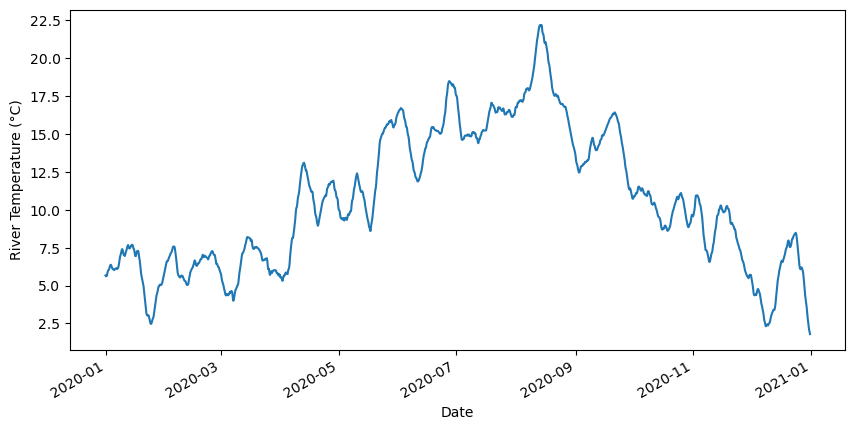

In [63]:
# Plot of temperature profile for 2020

fig = plt.figure(figsize=(10, 5))

plt.plot(temp_2020_df['Time'],temp_2020_df['Temp_SMA'])
plt.xlabel('Date')
plt.ylabel('River Temperature (°C)')

fig.autofmt_xdate()

129.09891893809632
1767.9940186634349
<ipython-input-64-89ff70fdd3f4>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_2020_df['Temp_CHP_Input'][temp_2020_df['Temp_SMA'] < 3] = 3


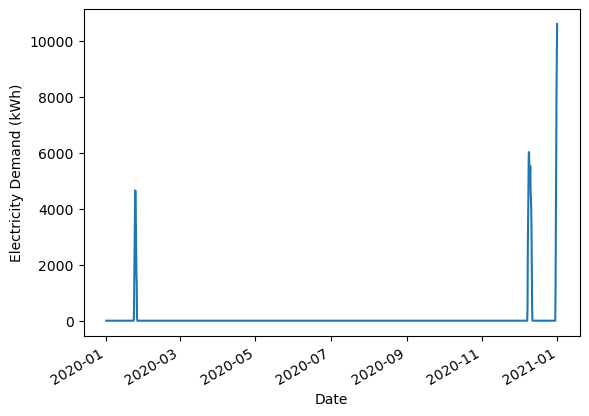

In [64]:
# Extracting points with river temperature < 3°C for input temperature
input_temp = np.zeros(len(temp_2020_df['Temp_SMA'])).T

for i in range(len(temp_2020_df['Temp_SMA'])):
    if temp_2020_df.iloc[i]['Temp_SMA'] < 3:
        input_temp[i] = temp_2020_df.iloc[i]['Temp_SMA']

# Creating boiler dataframe 
d = {'Time': temp_2020_df['Time'], 'Input_Temp': input_temp}
boiler_df = pd.DataFrame(data=d)

# Setting output temperature
desired_temp = 3
output_temp = np.zeros(len(temp_2020_df['Temp_SMA'])).T

for i in range(len(temp_2020_df['Temp_SMA'])):
    if temp_2020_df.iloc[i]['Temp_SMA'] < 3:
        output_temp[i] = 3

boiler_df['Output_Temp'] = output_temp

# Calculating Electricity Demand 
delta_T = boiler_df['Output_Temp'] - boiler_df['Input_Temp']
boiler_df['Delta_T'] = delta_T

Q_boiler = 1467.882 * delta_T       # in kW
W_boiler = 6 * Q_boiler             # in kWh

boiler_df['Demand'] = W_boiler

fig = plt.figure()
plt.plot(boiler_df['Time'], boiler_df['Demand'])
plt.xlabel('Date')
plt.ylabel('Electricity Demand (kWh)')
fig.autofmt_xdate()

# Total Demand from boiler
Total_Boiler_Demand = boiler_df['Demand'].sum() / 1000
print(Total_Boiler_Demand)  # annual demand in MWh 

print(np.amax(Q_boiler))        # max heat output of boiler 

# Implementing boiler to raise river temperature to 3°C 
temp_2020_df['Temp_CHP_Input'] = temp_2020_df['Temp_SMA']
temp_2020_df['Temp_CHP_Input'][temp_2020_df['Temp_SMA'] < 3] = 3


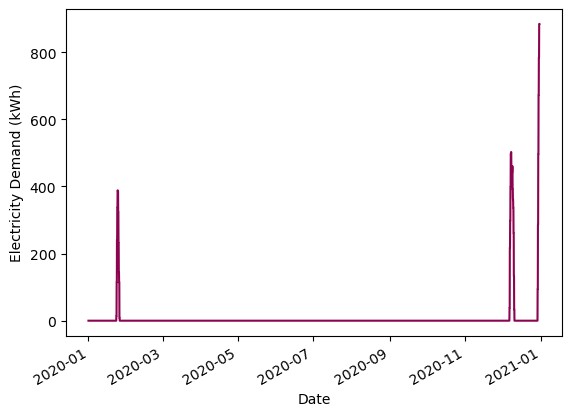

In [78]:
# Converting to 30 min data 
year = '2020'
dti = pd.date_range(year + '-01-01', periods=17520, freq="0.5H")
 
boiler_demand_30 = np.zeros(17520)
 
for i in range(len(boiler_df['Time'])):
  amount = boiler_df.iloc[i]['Demand']/ 12
  small_array = amount * np.ones(12)
  boiler_demand_30[i*12 : (i + 1)*12] = small_array

fig = plt.figure()
plt.plot(dti, boiler_demand_30,'#8c044F')
plt.xlabel('Date')
plt.ylabel('Electricity Demand (kWh)')
fig.autofmt_xdate()

In [66]:
# Creating csv file 
d = {'Time': dti, 'Demand': boiler_demand_30}
boiler_demand_df = pd.DataFrame(data=d)

boiler_demand_df.to_csv('boiler_demand.csv')


In [67]:
# Calculating COP
Network_temp = 273.15 + 12
Performance_factor = 0.1
T_network = np.full((len(temp_2020_df['Temp_SMA']),1), Network_temp)
T_river = np.array([temp_2020_df['Temp_CHP_Input'] + 273.15]).T

COP_2020_ideal = T_network / (T_network - T_river)
COP_2020 = (COP_2020_ideal) * Performance_factor

temp_2020_df['COP_centralHP'] = COP_2020

# removing any negative values of COP as this is when River Temperature > 12°C
#COP_2020_df = temperature_2020_df[temperature_2020_df['COP'] > 0]

# setting negative values of COP to very large number so that electricity output is 0 - needs better solution than this
# temp_2020_df.loc[temp_2020_df['COP'] < 0, ['COP']] = 10**10

# plt.plot(temp_2020_df['Time'], temp_2020_df['COP'])
# plt.xlabel('Date')
# plt.ylabel('COP')





(0.0, 30.0)

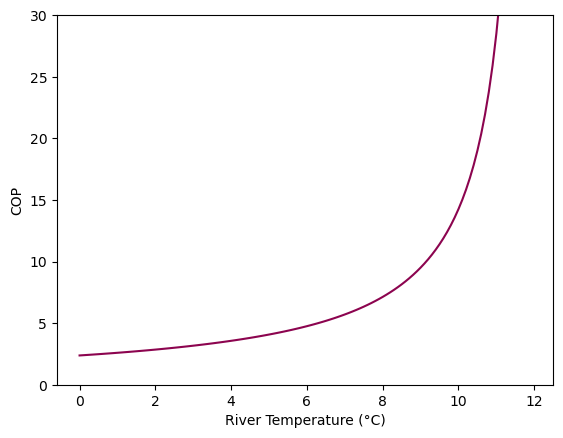

In [68]:
# Showing how COP varies with river temperature 
def f(T):
    return 0.1 * (12+273.15)/(12 - T)

T = np.arange(0, 12, 0.1)

plt.plot(T, f(T), '#8c044F')
plt.xlabel('River Temperature (°C)')
plt.ylabel('COP')

axes = plt.gca()
axes.set_ylim([0,30])


Text(0, 0.5, 'Electricity  (kWh)')

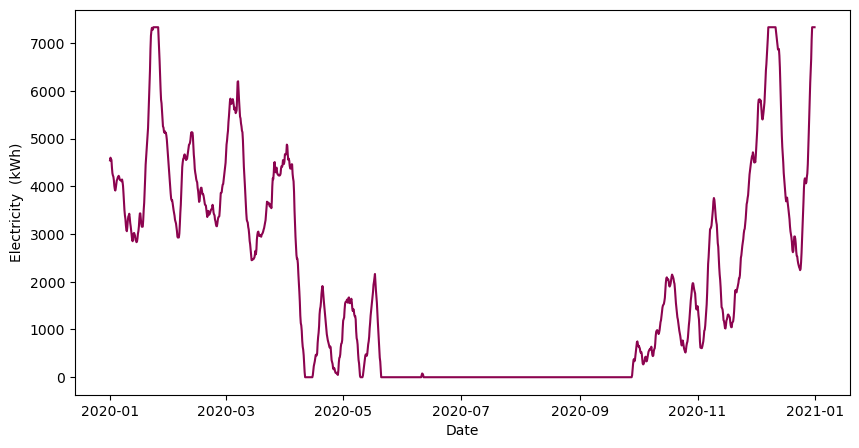

In [69]:
# calculating electricity requirement 
Qc = 2.65e3     # power in kW
COP = np.array([temp_2020_df['COP_centralHP']]).T

W = Qc / (COP - 1)      # power in kw need to convert to kWh
W = W.clip(min=0)       # set all negative values to 0
W = 6*W

temp_2020_df['Electricity'] = W

fig = plt.figure(figsize=(10, 5))
plt.plot(temp_2020_df['Time'], temp_2020_df['Electricity'], '#8c044F')
plt.xlabel('Date')
plt.ylabel('Electricity  (kWh)')


In [70]:
Total_Electricity_Demand = temp_2020_df['Electricity'].sum()
Total_Electricity_Demand = Total_Electricity_Demand / 1000      # total annual electricity demand in MWh

print (Total_Electricity_Demand)

2808.8178101248836


In [71]:
temp_2020_df['Electricity'].astype(bool).sum(axis=0)    #counting points with 0 output 

922

In [72]:
# Converting to 30 min data
year = '2020'
dti = pd.date_range(year + '-01-01', periods=17520, freq="0.5H")
 
demand_over_year = np.zeros(17520)
 
for i in range(len(temp_2020_df['Time'])):
  amount = temp_2020_df.iloc[i]['Electricity']/ 12
  small_array = amount * np.ones(12)
  demand_over_year[i*12 : (i + 1)*12] = small_array

Text(0, 0.5, 'Energy Demand (kWh)')

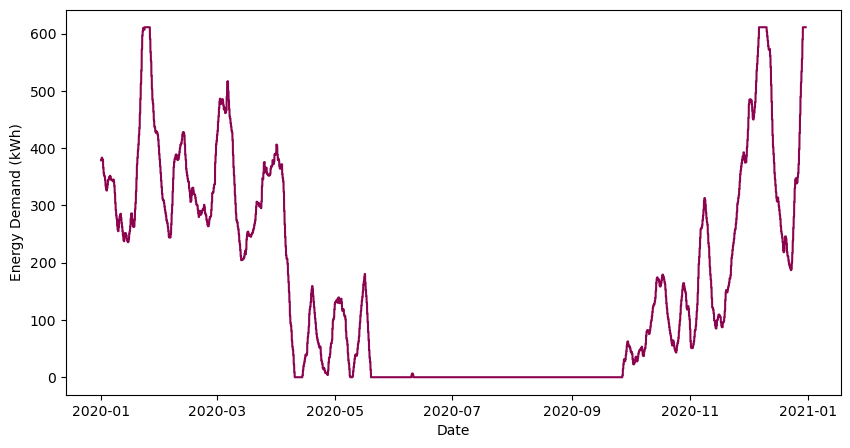

In [73]:
fig = plt.figure(figsize=(10, 5))
plt.plot(dti, demand_over_year,'#8c044F')
plt.xlabel('Date')
plt.ylabel('Energy Demand (kWh)')


In [74]:
d = {'Time': dti, 'Energy Demand': demand_over_year}
>>> centralheatpump_df = pd.DataFrame(data=d)

In [75]:
centralheatpump_df.to_csv('centralheatpump.csv')

In [76]:
# Calculating Q_H for period of maximum demand 
COP_maxdemand = COP[1459]
print(COP_maxdemand)

[3.16833333]


In [77]:
max(demand_over_year)

611.0684089162183